In [46]:
import warnings
warnings.filterwarnings("ignore")

import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import namedtuple

# from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score, classification_report,confusion_matrix,plot_confusion_matrix

In [47]:
train_dir = 'keyword.csv'
df_train = pd.read_csv(train_dir)
df_train_50 = pd.DataFrame(df_train,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_train_50.name = 'df_train_50'
df_train_100 = pd.DataFrame(df_train,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_train_100.name = 'df_train_100'
df_train_full = pd.DataFrame(df_train,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_train_full.name = 'df_train_full'
df_train_all = [df_train_100,df_train_full]

test_dir = "key_word_test.csv"
df_test = pd.read_csv(test_dir)
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

test_size = len(df_test)

In [48]:
topic_list = list(set(df_test['topic']))
topic_list.sort()
topic_dict = dict()
for num, topic in enumerate(topic_list):
    topic_dict[num] = topic
print(topic_dict)

{0: 'ARTS CULTURE ENTERTAINMENT', 1: 'BIOGRAPHIES PERSONALITIES PEOPLE', 2: 'DEFENCE', 3: 'DOMESTIC MARKETS', 4: 'FOREX MARKETS', 5: 'HEALTH', 6: 'IRRELEVANT', 7: 'MONEY MARKETS', 8: 'SCIENCE AND TECHNOLOGY', 9: 'SHARE LISTINGS', 10: 'SPORTS'}


In [50]:
# [[first_level_model_path, second_level_model_path],
#  [first_level_model_path, second_level_model_path],
#  ...
#  [first_level_model_path, second_level_model_path]]
model_paths = [["Raymond's_work/chosen models/rel_clf_tfidf_NB.joblib", "Raymond's_work/chosen models/clf_NB_1.joblib"],
               ["Raymond's_work/chosen models/rel_clf_tfidf_NB.joblib", "Raymond's_work/chosen models/clf_NB_2.joblib"],
               ["Raymond's_work/chosen models/rel_clf_tfidf_NB.joblib", "Raymond's_work/chosen models/clf_NB_1.joblib"],
               ["Shiyunze_work/ChosenModel/tfidf_logi_pipe.joblib"],
#                ["Yangqi's work/svm_proba.joblib"],
#                ["Yangqi's work/svm_proba.joblib"]
              ]

In [51]:
# data used by the models
model_data = [df_test_50, 
              df_test_100, 
              df_test_50, 
              df_test_50,
#               df_test_100,
#               df_test_full
             ]
model_preporc = []
# order of categories predicted accurately by the models
model_beliefs = [{9, 3, 0, 10, 2, 4}, 
                 {9, 3, 10, 5, 7, 2}, 
                 {1}, 
                 {0, 3, 10, 9, 5, 2}, 
#                  {0, 9, 3, 10, 2, 4, 5},
#                  {3, 10, 4, 5, 2}
                ]

In [80]:
# create a Vote structure include following information:
#    model: which model votes             - int
#    cate:  which category it votes       - int
#    proba: the probability it provides   - float
Vote = namedtuple("Vote", "model cate proba")

# since some cannot predict proba, try vote without proba, but probably get a draw vote
def print_vote(truth, votes):
    for num, (label, sample) in enumerate(zip(truth, votes)):        
        # vote_list to count vote, init with 11 zeros
        vote_list = [0 for _ in range(len(topic_list))]
        for vote in sample:
            vote_list[vote.cate] += 1
            
        # get category chosen by vote
        max_vote = max(vote_list)
        # 
        if max_vote == 0:
            raise ValueError("No valid vote")
        if vote_list.count(max_vote) > 1:
            raise ValueError("Draw vote")
        chosen_cate = vote_list.index(max_vote)
        print(num, label, topic_dict[chosen_cate])


def vote_proba(truth, votes):
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)
    for num, (label, sample) in enumerate(zip(truth, votes)):        
        # vote_list to count vote, init with 11 zeros
        vote_list = [0 for _ in range(len(topic_list))]
        vote_probas = [[] for _ in range(len(topic_list))]
        vote_proba_mean = [0 for _ in range(len(topic_list))]
        for vote in sample:
            vote_list[vote.cate] += 1
            vote_probas[vote.cate].append(vote.proba)
            
        for i in range(len(topic_list)):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
                print(vote_proba_mean[i])
            
        # get category chosen by vote
        max_vote = max(vote_list)
        # 
        if max_vote == 0:
            raise ValueError("No valid vote")
        if vote_list.count(max_vote) > 1:
            chosen_cate = vote_proba_mean.index(max(vote_proba_mean))
        else:
            chosen_cate = vote_list.index(max_vote)
        new_row = pd.Series([label, topic_dict[chosen_cate], vote_proba_mean[chosen_cate], [s.model for s in sample if s.cate==chosen_cate], [s.proba for s in sample if s.cate==chosen_cate]], index=column_names)
        df = df.append(new_row, ignore_index=True)
    return df

In [81]:
# after first level, change 0 to 6
CLASS_IRRE = 6

all_votes = [[] for _ in range(test_size)]

for model_num, (data, path) in enumerate(zip(model_data, model_paths)):
    # if path have two strings, means model have 2 levels
    if len(path) == 2:
        # prediction at first level (i.e., relevant vs irrelevant)
        model_1 = joblib.load(path[0])
        y_pred_1 = model_1.predict(data['key_word'])
        y_pred_proba_1 = model_1.predict_proba(data['key_word'])
        for i in range(test_size):
            cate_1, proba_1 = y_pred_1[i], y_pred_proba_1[i]
            if cate_1 == 0:
                all_votes[i].append(Vote(model_num, CLASS_IRRE, proba_1[cate_1]))

        # prediction at second level
        model_2 = joblib.load(path[1])
        y_pred_2 = model_2.predict(data['key_word'])
        y_pred_proba_2 = model_2.predict_proba(data['key_word'])
        for i in range(test_size):
            # cate_1 use to distinguish relavent
            cate_1 = y_pred_1[i]
            cate_2, proba_2 = y_pred_2[i], y_pred_proba_2[i]
            accu_class = model_beliefs[model_num]

            # if first level predict relevant, predict by 2 level
            # if it's accurately classified by the first level, vote is valid
            if cate_1 == 1 and cate_2 in accu_class:
                all_votes[i].append(Vote(model_num, cate_2, proba_2[cate_2]))
    
    # if path have 1 string, means model have 1 level
    else:
        model = joblib.load(path[0])
        y_pred = model.predict(data['key_word'])
        y_pred_proba = model.predict_proba(data['key_word'])
        for i in range(test_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            accu_class = model_beliefs[model_num]

            # if first level predict relevant, predict by 2 level
            # if it's accurately classified by the first level, vote is valid
            if cate in accu_class:
                all_votes[i].append(Vote(model_num, cate, proba[cate]))

res_df = vote_proba(df_test['topic'], all_votes)

1.0
0.9612146787953262
0.9998835427888001
0.9829160686224298
0.9999999999997726
0.9999999999401215
1.0
1.0
0.9999999999995453
0.7305747111275886
0.9816859822190543
0.999999999998181
0.9999999965885541
1.0
0.9950404576047726
0.780884397752738
0.9999158684015305
0.9999999999997348
0.9995766798759105
1.0
1.0
1.0
1.0
0.9999973239539305
0.9999999925890203
0.9999999969096258
1.0
1.0
0.99155833216092
0.9999999999999242
0.9999999992235189
0.9999953411685805
0.874844523744077
0.9999989507198386
1.0
0.999999999398824
0.9999999992150302
0.9505081576968146
1.0
0.5001970633869977
0.9999999999907914
0.9999999969908231
0.9999991633554917
0.9999999997867235
0.9998209343571055
0.9999998187751253
0.9990675072070639
1.0
0.8115865031766001
0.9923802168220289
0.9178595444675062
0.9707768424611899
0.700766489593643
0.9999999989513148
0.9999999999643023
0.9999453114121866
0.5237446048749818
0.9999999991988489
0.9995745195306244
0.9999999999197987
0.9997678057203868
0.9989531361504692
0.9897414496806203
0.996

0.9995717335464324
0.9600459414559713
0.8378842753426605
0.9999999993497113
1.0
1.0
1.0
0.9644569424121388
1.0
0.9514419216931106
0.9999793969345163
1.0
0.9999999999991663
0.9999960526931804
0.9983598373082425
0.9979222612280837
1.0
0.9408144623769932
0.9999999999987873
0.9999997829978774
0.9528614933008374
0.9717515471237933
1.0
0.9998644534716733
0.9256056454980938
0.9454567465778908
0.9995766054382695
0.9999999864849847
1.0
0.9971888995525028
0.9999319537291029
0.9999999999994316
0.9999999999992051
1.0
1.0
1.0
0.9999990811381361
0.6280816661746205
0.9999694260106442
0.9988188633379768
0.918095078323605
0.9998259692490299
1.0
1.0
0.9999596376998247
1.0
0.9999999998295549
0.9378545317243754
0.9918784113889526
1.0
0.9918299396113058
0.9999243622084654
0.9999999986703187
0.999998881020077
0.9999992439691725
1.0
1.0
0.9977813030243086
0.9999999992885512
0.9999999992517132
0.999999986549483
1.0
0.999999996553394
0.5233573757700416
0.9835044171201361
0.9630571792839209
0.8872019675853338
0

In [82]:
res_df

,label,predict,mean_proba,models,probas
0,IRRELEVANT,IRRELEVANT,1.000000,"[0, 1, 2]","[1.0, 1.0, 1.0]"
1,IRRELEVANT,IRRELEVANT,0.999884,[1],[0.9998835427888001]
2,FOREX MARKETS,MONEY MARKETS,1.000000,[1],[0.9999999999997726]
3,IRRELEVANT,IRRELEVANT,1.000000,"[0, 1, 2]","[1.0, 1.0, 1.0]"
4,IRRELEVANT,IRRELEVANT,1.000000,"[0, 1, 2]","[1.0, 1.0, 1.0]"
...,...,...,...,...,...
495,IRRELEVANT,IRRELEVANT,1.000000,"[0, 1, 2]","[1.0, 1.0, 1.0]"
496,SPORTS,SPORTS,1.000000,"[0, 1, 3]","[1.0, 1.0, 1.0]"
497,MONEY MARKETS,MONEY MARKETS,1.000000,[1],[1.0]
498,SHARE LISTINGS,IRRELEVANT,0.910855,"[0, 1, 2]","[0.8663024771360115, 0.999959310253058, 0.8663..."


In [ ]:
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    
def

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.40      0.67      0.50         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.60      0.40      0.48        15
                         DEFENCE       0.59      0.77      0.67        13
                DOMESTIC MARKETS       0.50      0.50      0.50         2
                   FOREX MARKETS       0.40      0.60      0.48        48
                          HEALTH       0.64      0.50      0.56        14
                      IRRELEVANT       0.87      0.75      0.80       266
                   MONEY MARKETS       0.53      0.65      0.58        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.20      0.14      0.17         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.72       500
             

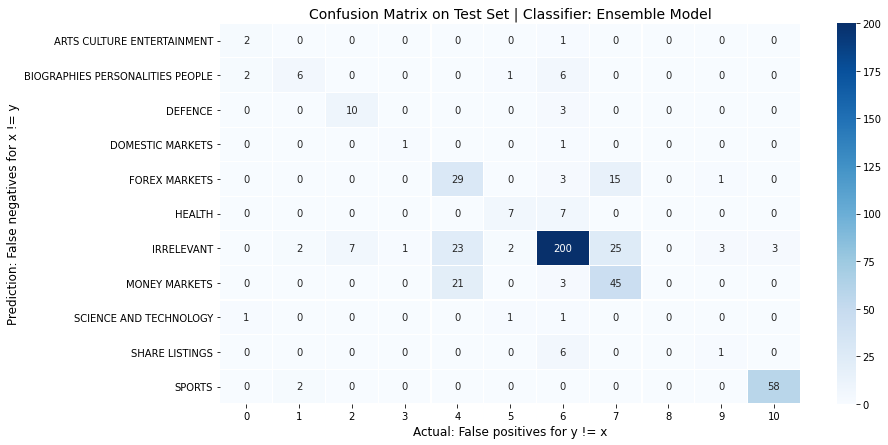

In [26]:
def report(test_y, y_pred):
    global topic_list

    print(f"Classification Report:\n{classification_report(test_y, y_pred)}")
#     print("The scores for each topic is:")
#     scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,7))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=topic_list,
#                 xticklabels=topic_list,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: Ensemble Model", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

report(res_df['label'], res_df['predict'])

In [92]:
for topic in topic_list:
    if topic != "irrelavant":
        df_filter = res_df[res_df['predict'] == topic]
        print(topic, df_filter.sort_values(by="mean_proba").head(10).index.tolist())

ARTS CULTURE ENTERTAINMENT [451, 103, 329, 202, 432]
BIOGRAPHIES PERSONALITIES PEOPLE [25, 310, 74, 81, 257, 395, 439, 455, 482, 487]
DEFENCE [454, 403, 78, 272, 106, 230, 269, 238, 220, 296]
DOMESTIC MARKETS [408, 493]
FOREX MARKETS [373, 252, 164, 113, 41, 367, 414, 133, 224, 176]
HEALTH [353, 446, 372, 116, 309, 425, 160, 108, 120, 428]
IRRELEVANT [391, 153, 456, 197, 34, 216, 221, 360, 22, 277]
MONEY MARKETS [468, 433, 86, 460, 396, 49, 365, 415, 99, 181]
SCIENCE AND TECHNOLOGY []
SHARE LISTINGS [445, 471, 167, 225, 214]
SPORTS [308, 107, 300, 463, 480, 19, 35, 317, 320, 235]
